# Imports

In [2]:
#Import all the necessary python libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import json
from scipy.integrate import trapz

#Import all the necessary CLAW libraries
import create_directory
import CLAW
import matplotlib.pyplot as plt
import warnings

import OzESI_CLAW

import re
from sklearn.mixture import GaussianMixture
import tqdm

import OzESI_CLAW
# import OzESI
# import OzESI_plot
# import OzESI_compare




#version 2
import OzESI
from OzESI_plot import Plot
# Import the create_folder function from OzESI_utils
from OzESI_utils import create_folder, create_base_directory, generate_filename, save_for_ozone_compare, create_project_folder, filter_o3mzml_files, create_all_folders
from OzESI_compare import OzoneCompare


# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
name_of_project = 'AMP'


# Separate OzON and OzOFF mzml files incase they weren't seprated before

In [3]:
#After you load mzml files to mzml folder. this will filter the files and move them to o3on and o2only folders
filter_o3mzml_files(name_of_project)


# Rest of your script


The directory 'Projects/AMP/mzml' does not exist. Please try again with a valid directory.


# Database location, CLAW preparsing setup - ON/OFF switch

# updated again for ozone

In [4]:
# Define the mode: 'ON' or 'OFF'
mode = 'OFF'  # Change to 'ON' as needed

# Set default values based on the mode
if mode == 'ON':
    data_base_name_location = 'lipid_database/AMP_Database_OzON.xlsx'
    Project = './Projects/'
    Project_Name = 'AMP'
    Project_Folder_data = f'{Project}{Project_Name}/test3_on/'
    Project_results = f'{Project}{Project_Name}/results/AMP/'
    file_name_to_save = 'AMP'
    tolerance = 0.3
    remove_std = True
    save_data = True
    csv_data_folder = f'{Project_results}csv_data/'
    base_plot_directory = f'Projects/{Project_Name}/results/plots/on/'
    project_results_directory = f'Projects/{Project_Name}/results/AMP/'
    save_df_name = 'AMP_ON.csv'
    plots_directory = f'Projects/{Project_Name}/results/AMP/plots/on/'
    file_name = 'AMP_ON.csv'

#Updated_Lipid_Data.xlsx
#AMP_Database_OzOFF
else:
    data_base_name_location = 'lipid_database/AMP_Database_OzOFF.xlsx'
    Project = './Projects/'
    Project_Name = 'AMP'
    Project_Folder_data = f'{Project}{Project_Name}/AMP_OFF/'
    Project_results = f'{Project}{Project_Name}/results/AMP/'
    file_name_to_save = 'AMP'
    tolerance = 0.8
    remove_std = True
    save_data = True
    csv_data_folder = f'{Project_results}csv_data/'
    base_plot_directory = f'Projects/{Project_Name}/results/plots/off/'
    project_results_directory = f'Projects/{Project_Name}/results/AMP/'
    save_df_name = 'AMP_OFF.csv'
    plots_directory = f'Projects/{Project_Name}/results/AMP/plots/off/'
    file_name = 'AMP_OFF.csv'



# Define all necessary folder paths
folders_to_create = [
    csv_data_folder,
    base_plot_directory,
    project_results_directory,
    plots_directory
]

# Call the function to ensure all folders exist
create_all_folders(*folders_to_create)



# Save RawDataParser output CSV file
output_csv = f"{csv_data_folder}{file_name_to_save}_RawDataParser_{mode}.csv"
raw_data_csv = f"{csv_data_folder}{file_name_to_save}_RawDataParser_{mode}.csv"

# Path to the PeakAnalysis output CSV file
peak_analysis_csv = f"{csv_data_folder}{file_name_to_save}_PeakAnalysis_{mode}.csv"

# Paths to the CSV files
mrm_csv_path = f'{csv_data_folder}df_MRM_{mode}.csv'
oze_esi_csv_path = f'{csv_data_folder}df_OzESI_{mode}.csv'


# # Path to OzoneCompare files
# ozone_compare_csv = f"{csv_data_folder}{file_name_to_save}_OzoneCompared.csv"


# Call pre_parsing_setup to initialize the variables
data_base_name_location, Project_Folder_data, Project_results, file_name_to_save, tolerance, remove_std, save_data = OzESI_CLAW.pre_parsing_setup(data_base_name_location,
 Project, 
 Project_Name, 
 Project_Folder_data,
 Project_results, 
 file_name_to_save, 
 tolerance, 
 remove_std,
 save_data)


# # Save RawDataParser output CSV file
# output_csv = f"{csv_data_folder}{file_name_to_save}_RawDataParser_{mode}.csv"
# raw_data_csv = f"{csv_data_folder}{file_name_to_save}_RawDataParser_{mode}.csv"

# Path to the PeakAnalysis output CSV file
peak_analysis_csv_on = f"{file_name_to_save}_PeakAnalysis_ON.csv"
peak_analysis_csv_off = f"{file_name_to_save}_PeakAnalysis_OFF.csv"
ozone_compare_csv = f'{file_name}_OzoneCompared.csv'

Folder already exists: ./Projects/AMP/results/AMP/csv_data/
Folder already exists: Projects/AMP/results/plots/off/
Folder already exists: Projects/AMP/results/AMP/
Folder already exists: Projects/AMP/results/AMP/plots/off/
data_base_name_location: lipid_database/AMP_Database_OzOFF.xlsx
Project: ./Projects/
Project_Name: AMP
Project_Folder_data: ./Projects/AMP/AMP_OFF/
Project_results: ./Projects/AMP/results/AMP/
file_name_to_save: AMP
tolerance: 0.8
remove_std: True
save_data: True


# Database Location, Project Location, and CLAW Preparsing setup

# csv paths

In [5]:
# Define the retention time range and new columns
retention_time_range = (0, 15)
new_columns = {'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
               'Genotype': ['5xFAD', 'WT'],
               'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
               'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5']}
#group data
group_columns = ['Lipid', 'Sample_ID', 'Biology', 'Genotype', 'Mouse', 'Cage']

# OzESI setup

In [6]:


time_and_intensity_df, master_df, OzESI_time_df = OzESI_CLAW.create_analysis_dataframes()

# CLAW with OzESI

In [7]:
# Use the initialized variables as arguments to full_parse
df_MRM, df_OzESI = OzESI_CLAW.full_parse(data_base_name_location, 
                                               Project_Folder_data, 
                                               Project_results, 
                                               file_name_to_save, 
                                               tolerance, 
                                               remove_std=True, 
                                               save_data=False,
                                               batch_processing=True,
                                               plot_chromatogram=False)

/home/iyer95/CLAW/CLAW/lipid_platform/OzESI_CLAW.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Parent_Ion'] = np.round(lipid_MRM_data['Parent_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/OzESI_CLAW.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Product_Ion'] = np.round(lipid_MRM_data['Product_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/OzESI_CLAW.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Finished parsing mzML file: ./Projects/AMP/AMP_OFF/11162023_Blank-AMP_2x_MRMs_O3off_01.mzML

Finished parsing mzML file: ./Projects/AMP/AMP_OFF/11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-0_MRMs_O3off_01.mzML

Finished parsing mzML file: ./Projects/AMP/AMP_OFF/11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216-0_MRMs_O3off_01.mzML

Finished parsing mzML file: ./Projects/AMP/AMP_OFF/11162023_WT-m1-dienc-FAD245_AMP_2x_0.05uMd216-0_MRMs_O3off_01.mzML

Finished parsing mzML file: ./Projects/AMP/AMP_OFF/11162023_WT-m1-hippo-FAD245_AMP_2x_0.05uMd216-0_MRMs_O3off_01.mzML

Finished parsing mzML file: ./Projects/AMP/AMP_OFF/11162023_WT-m2-cereb-FAD246_AMP_2x_0.05uMd216-0_MRMs_O3off_01.mzML

Finished parsing mzML file: ./Projects/AMP/AMP_OFF/11162023_WT-m2-cortex-FAD249_AMP_2x_0.05uMd216-0_MRMs_O3off_01.mzML

Finished parsing mzML file: ./Projects/AMP/AMP_OFF/11162023_WT-m2-dienc-FAD249_AMP_2x_0.05uMd216-0_MRMs_O3off_01.mzML

Finished parsing mzML file: ./Projects/AMP/AMP_OFF/11162023_WT-m2-hippo-

# Double check DFs

In [8]:
#save both df as csv files in Project_results/csv_data using pandas
df_MRM.to_csv(f'{csv_data_folder}df_MRM_{mode}.csv')
df_OzESI.to_csv(f'{csv_data_folder}df_OzESI_{mode}.csv')
df_MRM.head(None)
df_OzESI




,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,NaN,227.1,183.0,0.011583,40.920002,11162023_Blank-AMP_2x_MRMs_O3off_01,227.1 -> 183.0
1,NaN,227.1,183.0,0.024483,40.820004,11162023_Blank-AMP_2x_MRMs_O3off_01,227.1 -> 183.0
2,NaN,227.1,183.0,0.037383,40.760002,11162023_Blank-AMP_2x_MRMs_O3off_01,227.1 -> 183.0
3,NaN,227.1,183.0,0.050317,40.740002,11162023_Blank-AMP_2x_MRMs_O3off_01,227.1 -> 183.0
4,NaN,227.1,183.0,0.063233,40.740002,11162023_Blank-AMP_2x_MRMs_O3off_01,227.1 -> 183.0
...,...,...,...,...,...,...,...
4796605,NaN,533.5,183.0,29.949033,42.920002,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
4796606,NaN,533.5,183.0,29.961967,43.360004,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
4796607,NaN,533.5,183.0,29.974883,50.240002,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
4796608,NaN,533.5,183.0,29.987800,41.440002,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0


In [9]:
## print unique valies for Lipid in df_MRM
print(df_MRM['Lipid'].unique())

[nan '5:0' '6:0' '7:0' '8:1' '8:0' '9:1' '9:0' '10:1' '10:0' '11:2' '11:0'
 '12:2' '12:1' '12:0' '13:2' '13:1' '13:0' '14:3' '14:1' '14:0' '15:3'
 '15:2' '15:1' '15:0' '16:2' '16:1' '16:0' 'd2-16:0' '17:4' '17:1' '17:0'
 '18:4' '18:3' '18:2' '18:1' '18:0' '19:0' '20:5' '20:4' '20:3' '20:2'
 '20:1' '20:0' '21:0' '22:6' '22:2' '22:1' '22:0' '23:0' '24:1' '24:0']


In [10]:
# Assuming the correct column name is identified as 'lipid_name'
unique_lipid_names = df_MRM['Lipid'].unique()
print(unique_lipid_names)


df_MRM.tail(50)

[nan '5:0' '6:0' '7:0' '8:1' '8:0' '9:1' '9:0' '10:1' '10:0' '11:2' '11:0'
 '12:2' '12:1' '12:0' '13:2' '13:1' '13:0' '14:3' '14:1' '14:0' '15:3'
 '15:2' '15:1' '15:0' '16:2' '16:1' '16:0' 'd2-16:0' '17:4' '17:1' '17:0'
 '18:4' '18:3' '18:2' '18:1' '18:0' '19:0' '20:5' '20:4' '20:3' '20:2'
 '20:1' '20:0' '21:0' '22:6' '22:2' '22:1' '22:0' '23:0' '24:1' '24:0']


,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition
2205,FA,6.812265e+05,7:0,297.2,183.0,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,297.2 -> 183.0
2206,FA,1.721596e+05,8:1,309.1,183.0,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,309.1 -> 183.0
2207,FA,1.722965e+06,8:0,311.3,183.0,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,311.3 -> 183.0
2208,FA,2.386425e+05,9:1,323.2,183.0,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,323.2 -> 183.0
2209,FA,1.331800e+07,9:0,325.2,183.0,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,325.2 -> 183.0
2210,FA,2.863173e+05,10:1,337.2,183.0,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,337.2 -> 183.0
2211,FA,6.432494e+06,10:0,339.3,183.0,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,339.3 -> 183.0
2212,FA,1.400858e+05,11:2,349.2,183.0,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,349.2 -> 183.0
2213,FA,1.912732e+06,11:0,353.3,183.0,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,353.3 -> 183.0
2214,FA,1.976682e+05,12:2,363.3,183.0,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,363.3 -> 183.0


# Run RawDataParser
### 

/home/iyer95/CLAW/CLAW/lipid_platform/OzESI.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Match_Group'] = df.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()


Directory already exists at Projects/AMP/results/AMP/csv_data/
Directory already exists at Projects/AMP/results/AMP/csv_data/


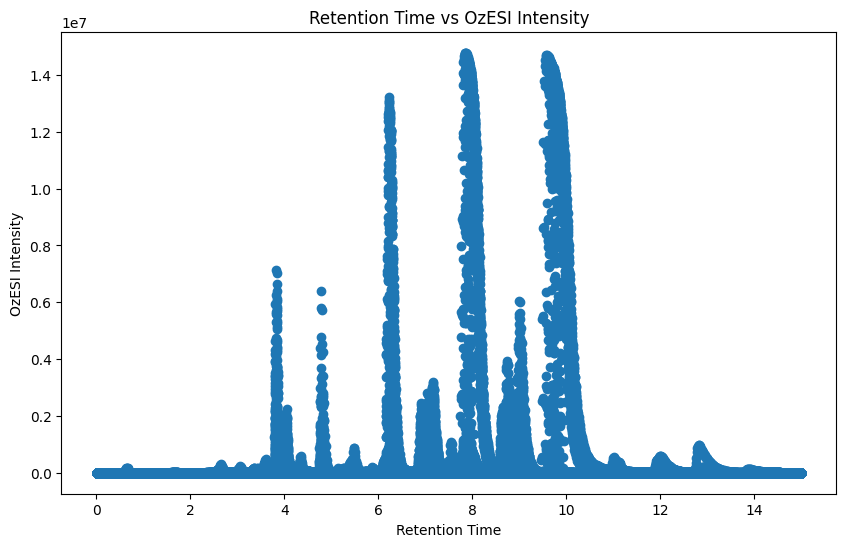

In [11]:
parser = OzESI.RawDataParser(mrm_csv_path, oze_esi_csv_path)


# Parse the data
parsed_data = parser.parse_data(retention_time_range, new_columns, group_columns, project_results_directory, file_name_to_save, mode)

# Save raw data
save_status = parser.save_raw_data(project_results_directory, file_name_to_save, mode)

# Plot the full spectrum
parser.plot_full_spectrum(raw_data_csv)

# Plot the full spectrum

In [12]:
read = pd.read_csv(raw_data_csv)
# Assuming the correct column name is identified as 'lipid_name'
unique_lipid_names = read['Lipid'].unique()
print(unique_lipid_names)




[nan '5:0' '6:0' '7:0' '8:1' '8:0' '9:1' '9:0' '10:1' '10:0' '11:2' '11:0'
 '12:2' '12:1' '12:0' '13:2' '13:1' '13:0' '14:3' '14:1' '14:0' '15:3'
 '15:2' '15:1' '15:0' '16:2' '16:1' '16:0' 'd2-16:0' '17:4' '17:1' '17:0'
 '18:4' '18:3' '18:2' '18:1' '18:0' '19:0' '20:5' '20:4' '20:3' '20:2'
 '20:1' '20:0' '21:0' '22:6' '22:2' '22:1' '22:0' '23:0' '24:1' '24:0']


In [13]:
# Print the parsed data
print(parsed_data)



RawDataParser complete, output saved to Projects/AMP/results/AMP/csv_data/AMP_RawDataParser_OFF.csv


# PeakAnalysis Class
### find peaks, RT and peak area 
### input df from RawDataParser and output is df

In [14]:
import pandas as pd
from scipy.signal import find_peaks, peak_widths
from typing import Optional
import os

def create_folder(path: str):
    if not os.path.exists(path):
        os.makedirs(path)

class PeakAnalysis:
    def __init__(self, raw_data_csv: str, mode: str):
        self.data = pd.read_csv(raw_data_csv)
        self.mode = mode

    def find_lipid_peaks(
        self, 
        use_match_group: bool = True, 
        height: int = 1000, 
        width: Optional[float] = None, 
        rel_height: float = 0.5, 
        project_results: Optional[str] = None, 
        file_name_to_save: Optional[str] = None, 
        user_input: str = "OFF"
    ) -> pd.DataFrame:
        if user_input not in ["ON", "OFF"]:
            raise ValueError("user_input must be 'ON' or 'OFF'")
        
        filter_col = 'Match_Group' if use_match_group else 'Group_Sample'
        unique_groups = self.data[filter_col].unique()
        peak_data = []

        for group in unique_groups:
            group_data = self.data[self.data[filter_col] == group]
            peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=height, width=width)
            results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=rel_height)

            # Calculate sampling interval
            retention_times = group_data['Retention_Time'].values
            if len(retention_times) > 1:
                sampling_interval = retention_times[1] - retention_times[0]
            else:
                sampling_interval = 1  # Fallback value in case there's only one retention time

            print(f"Sampling Interval: {sampling_interval}")

            for i, peak in enumerate(peaks):
                metadata = group_data.iloc[peak][['Parent_Ion', 'Product_Ion', 'FAC', 'Group_Sample', 'Match_Group', 'Biology', 'Genotype', 'Cage', 'Mouse', 'Lipid']]
                left_ip = results_half[2][i]
                right_ip = results_half[3][i]
                left_time = group_data['Retention_Time'].iloc[int(left_ip)]
                right_time = group_data['Retention_Time'].iloc[int(right_ip)]
                width_in_time = right_time - left_time

                fwhm = results_half[0][i] * sampling_interval

                print(f"Group_Sample: {metadata['Group_Sample']} - Peak {i}: Start Time = {left_time}, End Time = {right_time}, Width = {width_in_time}, FWHM = {fwhm}")

                peak_data.append({
                    'Lipid': metadata['Lipid'],
                    'Retention_Time': group_data.iloc[peak]['Retention_Time'],
                    'OzESI_Intensity': group_data.iloc[peak]['OzESI_Intensity'],
                    'Match_Group': metadata['Match_Group'],
                    'Group_Sample': metadata['Group_Sample'],
                    'Sample_ID': group_data.iloc[peak]['Sample_ID'],
                    'Parent_Ion': metadata['Parent_Ion'],
                    'Product_Ion': metadata['Product_Ion'],
                    'FAC': metadata['FAC'],
                    'Biology': metadata['Biology'],
                    'Genotype': metadata['Genotype'],
                    'Cage': metadata['Cage'],
                    'Mouse': metadata['Mouse'],
                    'Peak_Height': properties['peak_heights'][i],
                    'FWHM': fwhm,
                    'Peak_Width': width_in_time,
                    'Peak_Area': properties['peak_heights'][i] * width_in_time
                })

        peaks_df = pd.DataFrame(peak_data)

        # Keep only the top 3 rows for each 'Lipid' grouping by the 'Group_Sample' column based on 'OzESI_Intensity'
        top3_peaks_df = peaks_df.sort_values(by=['Group_Sample', 'OzESI_Intensity'], ascending=[True, False])
        top3_peaks_df = top3_peaks_df.groupby(['Lipid', 'Group_Sample']).head(3).reset_index(drop=True)

        csv_data_folder = f'{project_results}csv_data/'
        create_folder(csv_data_folder)

        output_csv = f"{csv_data_folder}{file_name_to_save}_PeakAnalysis_{user_input}.csv"
        top3_peaks_df.to_csv(output_csv, index=False)
        return top3_peaks_df
    
    def plot_data_and_peaks(self, raw_data_csv, peak_analysis_csv, group_value, group_type='Match_Group', height=50000, width=None, rel_height=0.5):
            # Read the raw data CSV file into a DataFrame
            raw_df = pd.read_csv(raw_data_csv)

            # Read the peak analysis CSV file into a DataFrame
            peak_df = pd.read_csv(peak_analysis_csv)

            if group_type not in ['Match_Group', 'Group_Sample']:
                raise ValueError("group_type must be 'Match_Group' or 'Group_Sample'")

            # Filter the DataFrame based on the specified group value
            filtered_raw_df = raw_df[raw_df[group_type] == group_value]
            filtered_peak_df = peak_df[peak_df[group_type] == group_value]

            if filtered_raw_df.empty:
                print(f"No data found for group {group_value} ({group_type})")
                return

            # Calculate the sampling interval
            retention_times = filtered_raw_df['Retention_Time'].values
            sampling_interval = retention_times[1] - retention_times[0]

            # Plot the full spectrum data
            plt.figure(figsize=(10, 6))
            plt.plot(filtered_raw_df['Retention_Time'], filtered_raw_df['OzESI_Intensity'], color='blue', label='Intensity vs. Retention Time')
            if not filtered_raw_df.empty:
                first_peak = filtered_raw_df.iloc[0]
                title_info = f"{first_peak['Lipid']}, MG {first_peak['Match_Group']}, GS {first_peak['Group_Sample']}, {first_peak['Parent_Ion']}, {first_peak['FAC']}, {first_peak['Biology']}, {first_peak['Genotype']}, {first_peak['Cage']}, {first_peak['Mouse']}"
                plt.title(title_info)
            plt.xlabel('Retention Time')
            plt.ylabel('OzESI Intensity')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Plot the peak data
            peaks, properties = find_peaks(filtered_raw_df['OzESI_Intensity'], height=height, width=width)
            results_half = peak_widths(filtered_raw_df['OzESI_Intensity'], peaks, rel_height=rel_height)

            # Convert peak widths to retention time units
            left_ips = results_half[2]
            right_ips = results_half[3]
            peak_widths_in_time = (right_ips - left_ips) * sampling_interval

            plt.figure(figsize=(10, 6))
            plt.plot(filtered_raw_df['Retention_Time'], filtered_raw_df['OzESI_Intensity'], color='gray', alpha=0.5, label='Full Data')
            plt.scatter(filtered_raw_df.iloc[peaks]['Retention_Time'], filtered_raw_df.iloc[peaks]['OzESI_Intensity'], color='red', label='Peaks')
            
            # Plot peak widths using the converted time units and vertical lines for start and stop times
            for left_ip, right_ip, height in zip(left_ips, right_ips, results_half[1]):
                left_time = filtered_raw_df['Retention_Time'].iloc[int(left_ip)]
                right_time = filtered_raw_df['Retention_Time'].iloc[int(right_ip)]
                plt.hlines(y=height, xmin=left_time, xmax=right_time, color='blue', linestyle='--', label='Peak Width')
                plt.axvline(x=left_time, color='green', linestyle=':', label='Peak Start' if 'Peak Start' not in plt.gca().get_legend_handles_labels()[1] else "")
                plt.axvline(x=right_time, color='purple', linestyle=':', label='Peak Stop' if 'Peak Stop' not in plt.gca().get_legend_handles_labels()[1] else "")

            plt.xlabel('Retention Time')
            plt.ylabel('OzESI Intensity')
            plt.legend()
            plt.title(f"Peaks for Group {group_value} ({group_type})")
            plt.grid(True)
            plt.show()


In [15]:

# # Create an instance of PeakAnalysis
#peak_analysis = OzESI.PeakAnalysis(raw_data_csv, mode)

peak_analysis = PeakAnalysis(raw_data_csv, mode)

# Perform peak analysis
peaks_df = peak_analysis.find_lipid_peaks(use_match_group=True, height=5000, width=2, rel_height=0.5, project_results=Project_results, file_name_to_save=file_name_to_save, user_input=mode)


Sampling Interval: 0.012900000000000002
Sampling Interval: 0.0129
Sampling Interval: 0.0129
Group_Sample: -1 - Peak 0: Start Time = 0.6313166666666667, End Time = 0.7217666666666667, Width = 0.09044999999999992, FWHM = 0.08698749017127795
Sampling Interval: 0.012900000000000002
Group_Sample: -1 - Peak 0: Start Time = 2.5821, End Time = 2.672533333333333, Width = 0.09043333333333292, FWHM = 0.08078893782378391
Sampling Interval: 0.0129
Group_Sample: -1 - Peak 0: Start Time = 0.6050833333333334, End Time = 0.6696833333333334, Width = 0.06459999999999999, FWHM = 0.06370659225991004
Group_Sample: -1 - Peak 1: Start Time = 3.0211833333333336, End Time = 3.0987, Width = 0.07751666666666646, FWHM = 0.07509156541702937
Sampling Interval: 0.0129
Group_Sample: -1 - Peak 0: Start Time = 3.3052333333333337, End Time = 3.3698333333333337, Width = 0.06459999999999999, FWHM = 0.06671347176766343
Sampling Interval: 0.012916666666666698
Sampling Interval: 0.0129166666666667
Group_Sample: -1 - Peak 0: S

In [16]:
peaks_df.tail(50)

############### WRITE A FUNCTION TO EASILY SCAN FOR SPECIFIC LIPIDS AN FIND THEIR MATCH GROUP OR GORUP SAMPLE
########## DOUBLE CHECK AREA CALCULATION

# Filter for Lipid 12:0 and Biology cereb
lipid_12_0_df = peaks_df[(peaks_df['Lipid'] == '18:1') & (peaks_df['Biology'] == 'cereb') & (peaks_df['Genotype'] == '5xFAD') & (peaks_df['Mouse'] == 'm1') & (peaks_df['Cage'] == 'FAD231')]
lipid_12_0_df
peaks_df


,Lipid,Retention_Time,OzESI_Intensity,Match_Group,Group_Sample,Sample_ID,Parent_Ion,Product_Ion,FAC,Biology,Genotype,Cage,Mouse,Peak_Height,FWHM,Peak_Width,Peak_Area
0,16:0,8.093783,5.930904e+06,1189,-1,11162023_Blank-AMP_2x_MRMs_O3off_01,423.3,183.0,['16:0'],NaN,NaN,NaN,NaN,5.930904e+06,0.128884,0.129217,766371.709808
1,18:0,10.017067,3.162372e+06,1558,-1,11162023_Blank-AMP_2x_MRMs_O3off_01,451.4,183.0,['18:0'],NaN,NaN,NaN,NaN,3.162372e+06,0.171310,0.167967,531173.167583
2,9:0,3.834150,2.344492e+06,369,-1,11162023_Blank-AMP_2x_MRMs_O3off_01,325.2,183.0,['9:0'],NaN,NaN,NaN,NaN,2.344492e+06,0.059918,0.064600,151454.199350
3,14:0,6.325150,8.320922e+05,902,-1,11162023_Blank-AMP_2x_MRMs_O3off_01,395.3,183.0,['14:0'],NaN,NaN,NaN,NaN,8.320922e+05,0.085404,0.077517,64501.017579
4,17:0,9.126600,6.703246e+05,1353,-1,11162023_Blank-AMP_2x_MRMs_O3off_01,437.4,183.0,['17:0'],NaN,NaN,NaN,NaN,6.703246e+05,0.120650,0.116283,77947.581810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,d2-16:0,8.016067,5.962646e+05,1266,2035,11192023_5xFAD-m2-cortex-FAD257_AMP_2x_0.05uMd...,425.4,183.0,['16:0'],cortex,5xFAD,FAD257,m2,5.962646e+05,0.110670,0.103350,61623.948994
2983,d2-16:0,7.990233,6.445334e+05,1267,2036,11192023_5xFAD-m2-dienc-FAD231_AMP_2x_0.05uMd2...,425.4,183.0,['16:0'],dienc,5xFAD,FAD231,m2,6.445334e+05,0.116563,0.116283,74948.489290
2984,d2-16:0,8.016050,5.532057e+05,1268,2037,11192023_5xFAD-m2-dienc-FAD257_AMP_2x_0.05uMd2...,425.4,183.0,['16:0'],dienc,5xFAD,FAD257,m2,5.532057e+05,0.111638,0.103367,57183.027898
2985,d2-16:0,7.990217,7.571184e+05,1269,2038,11192023_5xFAD-m2-hippo-FAD231_AMP_2x_0.05uMd2...,425.4,183.0,['16:0'],hippo,5xFAD,FAD231,m2,7.571184e+05,0.122146,0.116283,88040.248373


# vectorized df and Class

In [17]:
import pandas as pd

class SampleIDExtract:
    def __init__(self, retention_time_range=(0, 15), new_columns=None, key_name=None):
        if new_columns is None:
            new_columns = {
                'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
                'Genotype': ['5xFAD', 'WT'],
                'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
                'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5'],
                'Other': ['Blank', 'blank']
            }
        if key_name is None:
            key_name = ['Biology', 'Genotype', 'Mouse', 'Cage', 'Other']
        
        self.retention_time_range = retention_time_range
        self.new_columns = new_columns
        self.key_name = key_name

    def extract_unique_lipids_with_custom_group(self, peaks_df):
        """
        Extract unique lipids for each custom group from the given DataFrame.

        Parameters:
        peaks_df (DataFrame): DataFrame containing peaks data.

        Returns:
        DataFrame: DataFrame with the filtered lipids.
        """
        # Create a new column 'OzOFF_Possible' by combining the specified columns
        peaks_df['OzOFF_Possible'] = peaks_df[['Sample_ID', 'Biology', 'Genotype', 'Mouse', 'Cage']].astype(str).agg('_'.join, axis=1)

        # Initialize an empty list to store the results
        filtered_data = []

        # Group the DataFrame by 'OzOFF_Possible'
        grouped = peaks_df.groupby('OzOFF_Possible')

        # Iterate through the groups
        for group_sample, group_data in grouped:
            # Group by 'Lipid' within each custom group
            for lipid, lipid_data in group_data.groupby('Lipid'):
                if isinstance(lipid, str) and int(lipid.split(':')[1]) > 0:
                    # Find the row with the maximum OzESI_Intensity for each lipid
                    max_intensity_row = lipid_data.loc[lipid_data['OzESI_Intensity'].idxmax()]
                    retention_time = round(max_intensity_row['Retention_Time'], 2)
                    filtered_data.append([group_sample, lipid, retention_time])

        # Create a DataFrame from the filtered data
        OzOFF_lipids2 = pd.DataFrame(filtered_data, columns=['Sample_ID', 'Lipid', 'Retention_Time'])

        return OzOFF_lipids2

    def create_sample_column(self, df):
        """
        Create a new column 'Sample' by processing the 'Sample_ID' column.

        Parameters:
        df (DataFrame): DataFrame containing the 'Sample_ID' column.

        Returns:
        DataFrame: DataFrame with the new 'Sample' column.
        """
        def extract_sample_parts(sample_id):
            # Split the Sample_ID by underscore
            parts = sample_id.split('_')
            # Initialize a list to store matched parts
            matched_parts = []
            added_parts = set()

            # Identify parts that match the expected patterns
            for part in parts:
                if any(b in part for b in self.new_columns['Biology']):
                    match = next(b for b in self.new_columns['Biology'] if b in part)
                    if match not in added_parts:
                        matched_parts.append(match)
                        added_parts.add(match)
                elif any(g in part for g in self.new_columns['Genotype']):
                    match = next(g for g in self.new_columns['Genotype'] if g in part)
                    if match not in added_parts:
                        matched_parts.append(match)
                        added_parts.add(match)
                elif any(m in part for m in self.new_columns['Mouse']):
                    match = next(m for m in self.new_columns['Mouse'] if m in part)
                    if match not in added_parts:
                        matched_parts.append(match)
                        added_parts.add(match)
                elif any(c in part for c in self.new_columns['Cage']):
                    match = next(c for c in self.new_columns['Cage'] if c in part)
                    if match not in added_parts:
                        matched_parts.append(match)
                        added_parts.add(match)
                elif any(o in part for o in self.new_columns['Other']):
                    match = next(o for o in self.new_columns['Other'] if o in part)
                    if match not in added_parts:
                        matched_parts.append(match)
                        added_parts.add(match)

            # Join the relevant parts to create the Sample value
            return '_'.join(matched_parts)

        # Apply the extract_sample_parts function to each Sample_ID
        df['Sample'] = df['Sample_ID'].apply(extract_sample_parts)
        return df

    def generate_new_name(self, sample_id):
        parts = sample_id.split('_')
        new_name_parts = []
        for key in self.key_name:
            for part in parts:
                if key in part:
                    new_name_parts.append(part)
                    break
        new_name = '_'.join(new_name_parts)
        return new_name

# Variables below the class
retention_time_range = (0, 15)
new_columns = {'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
               'Genotype': ['5xFAD', 'WT'],
               'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
               'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5'],
               'Other': ['Blank', 'blank']}
key_name = ['Biology', 'Genotype', 'Mouse', 'Cage', 'Other']
csv_data_folder = "./"

# Assuming peaks_df is your DataFrame
# Create an instance of SampleIDExtract
sample_extractor = SampleIDExtract(retention_time_range, new_columns, key_name)

# Extract unique lipids and create the filtered DataFrame
OzOFF_lipids2 = sample_extractor.extract_unique_lipids_with_custom_group(peaks_df)

# Create the 'Sample' column
OzOFF_lipids2 = sample_extractor.create_sample_column(OzOFF_lipids2)

# Display the resulting DataFrame
print("OzOFF_lipids2:")
print(OzOFF_lipids2)

file_name_to_save = 'Possible_test'  # Adjust as needed
OzOFF_possible = f"{csv_data_folder}{file_name_to_save}_OzOFF_Possible.csv"

# Save the DataFrame to a CSV file
OzOFF_lipids2.to_csv(OzOFF_possible, index=False)

print(f"Filtered lipids data saved to: {OzOFF_possible}")


OzOFF_lipids2:
                                             Sample_ID Lipid  Retention_Time  \
0    11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  14:1            5.43   
1    11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  15:1            6.23   
2    11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  16:1            7.11   
3    11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  17:1            8.03   
4    11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  18:1            8.74   
..                                                 ...   ...             ...   
568  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...  18:3            4.13   
569  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...  20:1           10.49   
570  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...  20:5            5.88   
571  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...  22:6            0.65   
572  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...   9:1            3.71   

                    Samp

# adding species column

In [18]:
import pandas as pd

class SampleIDExtract:
    def __init__(self, retention_time_range=(0, 15), new_columns=None, key_name=None):
        if new_columns is None:
            new_columns = {
                'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
                'Genotype': ['5xFAD', 'WT'],
                'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
                'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5'],
                'Other': ['Blank', 'blank']
            }
        if key_name is None:
            key_name = ['Biology', 'Genotype', 'Mouse', 'Cage', 'Other']
        
        self.retention_time_range = retention_time_range
        self.new_columns = new_columns
        self.key_name = key_name

    def extract_unique_lipids_with_custom_group(self, peaks_df):
        """
        Extract unique lipids for each custom group from the given DataFrame.

        Parameters:
        peaks_df (DataFrame): DataFrame containing peaks data.

        Returns:
        DataFrame: DataFrame with the filtered lipids.
        """
        # Create a new column 'OzOFF_Possible' by combining the specified columns
        peaks_df['OzOFF_Possible'] = peaks_df[['Sample_ID', 'Biology', 'Genotype', 'Mouse', 'Cage']].astype(str).agg('_'.join, axis=1)

        # Initialize an empty list to store the results
        filtered_data = []

        # Group the DataFrame by 'OzOFF_Possible'
        grouped = peaks_df.groupby('OzOFF_Possible')

        # Iterate through the groups
        for group_sample, group_data in grouped:
            # Group by 'Lipid' within each custom group
            for lipid, lipid_data in group_data.groupby('Lipid'):
                if isinstance(lipid, str) and int(lipid.split(':')[1]) > 0:
                    # Find the row with the maximum OzESI_Intensity for each lipid
                    max_intensity_row = lipid_data.loc[lipid_data['OzESI_Intensity'].idxmax()]
                    retention_time = round(max_intensity_row['Retention_Time'], 2)
                    filtered_data.append([group_sample, lipid, retention_time, lipid])

        # Create a DataFrame from the filtered data
        OzOFF_lipids2 = pd.DataFrame(filtered_data, columns=['Sample_ID', 'Lipid', 'Retention_Time', 'Species'])

        return OzOFF_lipids2

    def create_sample_column(self, df):
        """
        Create a new column 'Sample' by processing the 'Sample_ID' column.

        Parameters:
        df (DataFrame): DataFrame containing the 'Sample_ID' column.

        Returns:
        DataFrame: DataFrame with the new 'Sample' column.
        """
        def extract_sample_parts(sample_id):
            # Split the Sample_ID by underscore
            parts = sample_id.split('_')
            # Initialize a list to store matched parts
            matched_parts = []
            added_parts = set()

            # Identify parts that match the expected patterns
            for part in parts:
                if any(b in part for b in self.new_columns['Biology']):
                    match = next(b for b in self.new_columns['Biology'] if b in part)
                    if match not in added_parts:
                        matched_parts.append(match)
                        added_parts.add(match)
                elif any(g in part for g in self.new_columns['Genotype']):
                    match = next(g for g in self.new_columns['Genotype'] if g in part)
                    if match not in added_parts:
                        matched_parts.append(match)
                        added_parts.add(match)
                elif any(m in part for m in self.new_columns['Mouse']):
                    match = next(m for m in self.new_columns['Mouse'] if m in part)
                    if match not in added_parts:
                        matched_parts.append(match)
                        added_parts.add(match)
                elif any(c in part for c in self.new_columns['Cage']):
                    match = next(c for c in self.new_columns['Cage'] if c in part)
                    if match not in added_parts:
                        matched_parts.append(match)
                        added_parts.add(match)
                elif any(o in part for o in self.new_columns['Other']):
                    match = next(o for o in self.new_columns['Other'] if o in part)
                    if match not in added_parts:
                        matched_parts.append(match)
                        added_parts.add(match)

            # Join the relevant parts to create the Sample value
            return '_'.join(matched_parts)

        # Apply the extract_sample_parts function to each Sample_ID
        df['Sample'] = df['Sample_ID'].apply(extract_sample_parts)
        return df

    def generate_new_name(self, sample_id):
        parts = sample_id.split('_')
        new_name_parts = []
        for key in self.key_name:
            for part in parts:
                if key in part:
                    new_name_parts.append(part)
                    break
        new_name = '_'.join(new_name_parts)
        return new_name


#csv folder data
csv_data_folder = f'{Project_results}csv_data/'

# Variables below the class
retention_time_range = (0, 15)
new_columns = {'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
               'Genotype': ['5xFAD', 'WT'],
               'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
               'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5'],
               'Other': ['Blank', 'blank']}
key_name = ['Biology', 'Genotype', 'Mouse', 'Cage', 'Other']

# Assuming peaks_df is your DataFrame
# Create an instance of SampleIDExtract
sample_extractor = SampleIDExtract(retention_time_range, new_columns, key_name)


# Extract unique lipids and create the filtered DataFrame
OzOFF_lipids2 = sample_extractor.extract_unique_lipids_with_custom_group(peaks_df)

# Create the 'Sample' column
OzOFF_lipids2 = sample_extractor.create_sample_column(OzOFF_lipids2)

# Display the resulting DataFrame
print("OzOFF_lipids2:")
print(OzOFF_lipids2)

file_name_to_save = 'Possible_test'  # Adjust as needed
OzOFF_possible = f"{csv_data_folder}{file_name_to_save}_OzOFF_Possible_species.csv"

# Save the DataFrame to a CSV file
OzOFF_lipids2.to_csv(OzOFF_possible, index=False)

print(f"Filtered lipids data saved to: {OzOFF_possible}")


OzOFF_lipids2:
                                             Sample_ID Lipid  Retention_Time  \
0    11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  14:1            5.43   
1    11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  15:1            6.23   
2    11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  16:1            7.11   
3    11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  17:1            8.03   
4    11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  18:1            8.74   
..                                                 ...   ...             ...   
568  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...  18:3            4.13   
569  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...  20:1           10.49   
570  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...  20:5            5.88   
571  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...  22:6            0.65   
572  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...   9:1            3.71   

    Species             

In [19]:
OzOFF_lipids2.head(15)

,Sample_ID,Lipid,Retention_Time,Species,Sample
0,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,14:1,5.43,14:1,Blank
1,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,15:1,6.23,15:1,Blank
2,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,16:1,7.11,16:1,Blank
3,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,17:1,8.03,17:1,Blank
4,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,18:1,8.74,18:1,Blank
5,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,18:2,7.56,18:2,Blank
6,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,20:5,6.15,20:5,Blank
7,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,22:6,0.65,22:6,Blank
8,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,9:1,3.71,9:1,Blank
9,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,14:1,5.42,14:1,cereb_WT_m1_FAD245


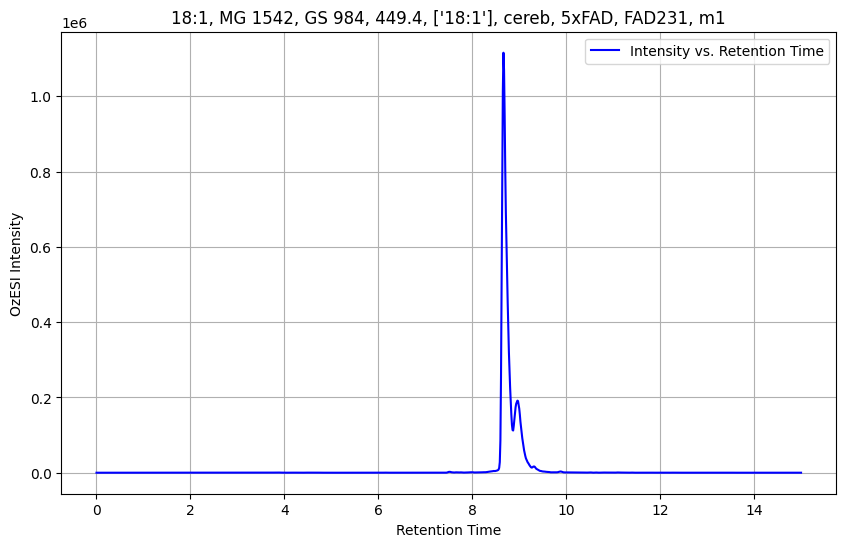

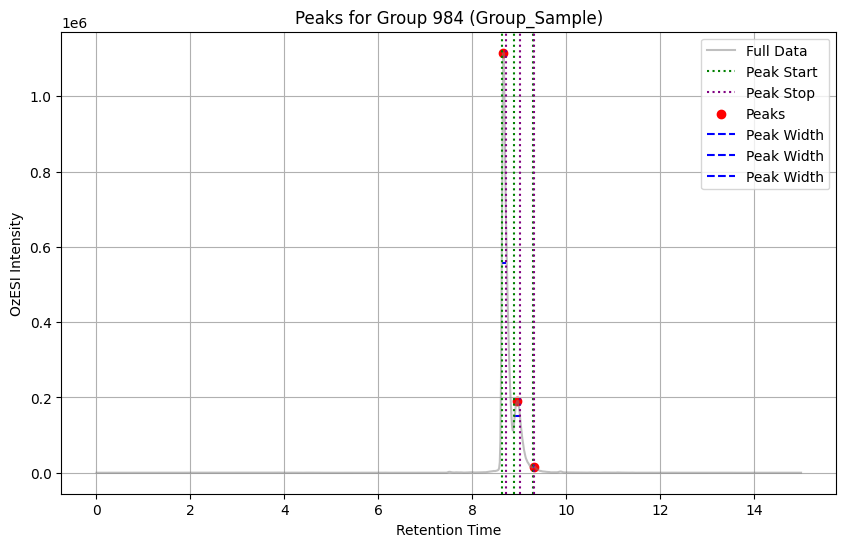

In [19]:
#920 959
# Plot data and peaks for a specific group
peak_analysis.plot_data_and_peaks(raw_data_csv, peak_analysis_csv,group_type='Group_Sample', group_value=984, height=5000, width=2, rel_height=0.5)

In [17]:
peaks_df

,Lipid,Retention_Time,OzESI_Intensity,Match_Group,Group_Sample,Sample_ID,Parent_Ion,Product_Ion,FAC,Biology,Genotype,Cage,Mouse,Peak_Height,FWHM,Peak_Width,Peak_Area
0,16:0,8.093783,5.930904e+06,1189,-1,11162023_Blank-AMP_2x_MRMs_O3off_01,423.3,183.0,['16:0'],NaN,NaN,NaN,NaN,5.930904e+06,0.128884,0.129217,766371.709808
1,18:0,10.017067,3.162372e+06,1558,-1,11162023_Blank-AMP_2x_MRMs_O3off_01,451.4,183.0,['18:0'],NaN,NaN,NaN,NaN,3.162372e+06,0.171310,0.167967,531173.167583
2,9:0,3.834150,2.344492e+06,369,-1,11162023_Blank-AMP_2x_MRMs_O3off_01,325.2,183.0,['9:0'],NaN,NaN,NaN,NaN,2.344492e+06,0.059918,0.064600,151454.199350
3,14:0,6.325150,8.320922e+05,902,-1,11162023_Blank-AMP_2x_MRMs_O3off_01,395.3,183.0,['14:0'],NaN,NaN,NaN,NaN,8.320922e+05,0.085404,0.077517,64501.017579
4,17:0,9.126600,6.703246e+05,1353,-1,11162023_Blank-AMP_2x_MRMs_O3off_01,437.4,183.0,['17:0'],NaN,NaN,NaN,NaN,6.703246e+05,0.120650,0.116283,77947.581810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,d2-16:0,8.016067,5.962646e+05,1266,2035,11192023_5xFAD-m2-cortex-FAD257_AMP_2x_0.05uMd...,425.4,183.0,['16:0'],cortex,5xFAD,FAD257,m2,5.962646e+05,0.110670,0.103350,61623.948994
2983,d2-16:0,7.990233,6.445334e+05,1267,2036,11192023_5xFAD-m2-dienc-FAD231_AMP_2x_0.05uMd2...,425.4,183.0,['16:0'],dienc,5xFAD,FAD231,m2,6.445334e+05,0.116563,0.116283,74948.489290
2984,d2-16:0,8.016050,5.532057e+05,1268,2037,11192023_5xFAD-m2-dienc-FAD257_AMP_2x_0.05uMd2...,425.4,183.0,['16:0'],dienc,5xFAD,FAD257,m2,5.532057e+05,0.111638,0.103367,57183.027898
2985,d2-16:0,7.990217,7.571184e+05,1269,2038,11192023_5xFAD-m2-hippo-FAD231_AMP_2x_0.05uMd2...,425.4,183.0,['16:0'],hippo,5xFAD,FAD231,m2,7.571184e+05,0.122146,0.116283,88040.248373


## PLOTS 

Looking for CSV file at: ./Projects/AMP/results/AMP/csv_data/AMP_PeakAnalysis_OFF.csv
Loaded DataFrame with 2987 rows and 17 columns.
DataFrame columns: Index(['Lipid', 'Retention_Time', 'OzESI_Intensity', 'Match_Group',
       'Group_Sample', 'Sample_ID', 'Parent_Ion', 'Product_Ion', 'FAC',
       'Biology', 'Genotype', 'Cage', 'Mouse', 'Peak_Height', 'FWHM',
       'Peak_Width', 'Peak_Area'],
      dtype='object')
Directory already exists at Projects/AMP/results/AMP/plots/off/
Lipid: 10:0, Data Points: 123, Intensities: [163130.65625, 7706.3603515625, 6037.6806640625, 297493.03125, 48662.14453125, 17302.701171875, 205185.65625, 53040.3828125, 21339.921875, 513357.53125, 97527.765625, 39290.90234375, 1196465.75, 86032.5078125, 40813.6015625, 175253.453125, 33503.86328125, 15114.6806640625, 647322.75, 77118.7421875, 41053.68359375, 275661.625, 65377.3828125, 20429.021484375, 230534.15625, 98485.484375, 16010.1416015625, 1077825.375, 51257.1640625, 33431.90234375, 655074.1875, 50232.125

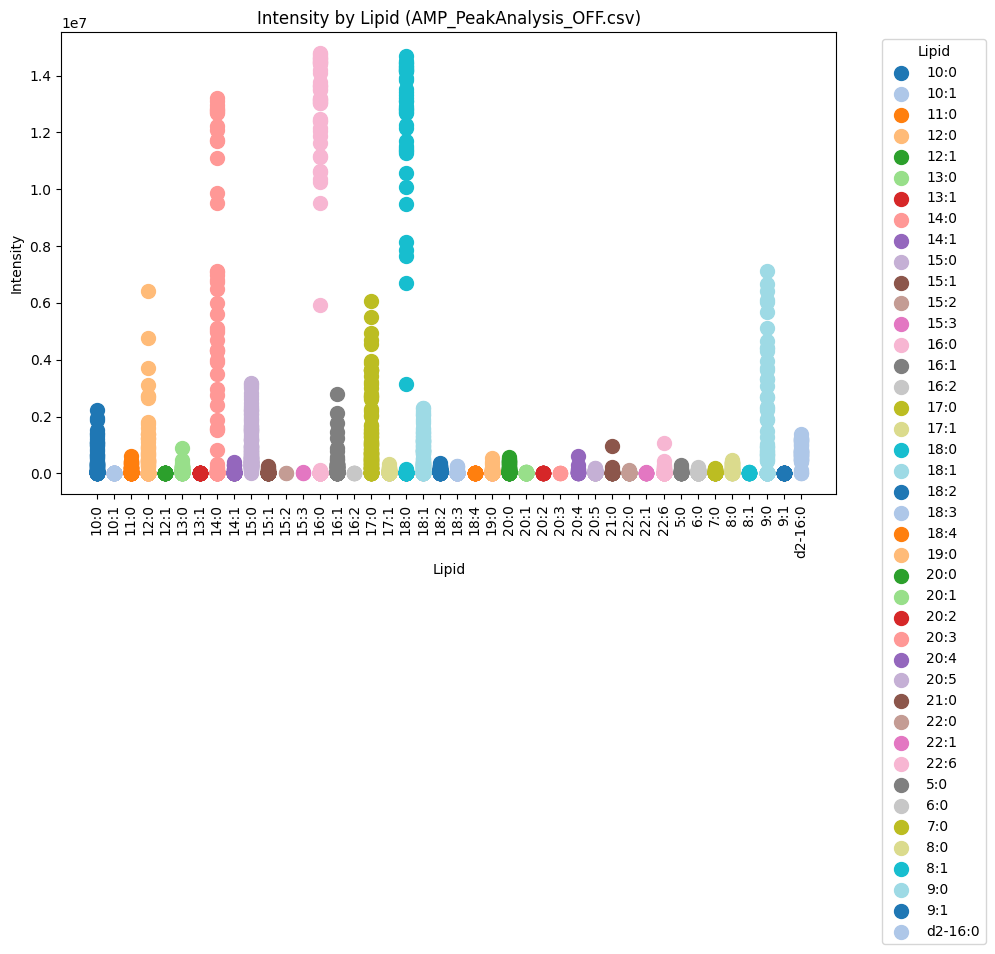

Looking for CSV file at: ./Projects/AMP/results/AMP/csv_data/AMP_PeakAnalysis_OFF.csv
Loaded DataFrame with 2987 rows and 17 columns.
DataFrame columns: Index(['Lipid', 'Retention_Time', 'OzESI_Intensity', 'Match_Group',
       'Group_Sample', 'Sample_ID', 'Parent_Ion', 'Product_Ion', 'FAC',
       'Biology', 'Genotype', 'Cage', 'Mouse', 'Peak_Height', 'FWHM',
       'Peak_Width', 'Peak_Area'],
      dtype='object')
Directory already exists at Projects/AMP/results/AMP/plots/off/
Grouped Data:       Lipid  OzESI_Intensity
0      10:0     2.227543e+06
1      10:1     1.297422e+04
2      11:0     6.056385e+05
3      12:0     6.402462e+06
4      12:1     2.675644e+04
5      13:0     8.778977e+05
6      13:1     1.594892e+04
7      14:0     1.321040e+07
8      14:1     3.989378e+05
9      15:0     3.183908e+06
10     15:1     2.644301e+05
11     15:2     2.507240e+04
12     15:3     3.294840e+04
13     16:0     1.478341e+07
14     16:1     2.799382e+06
15     16:2     1.530516e+04
16     17

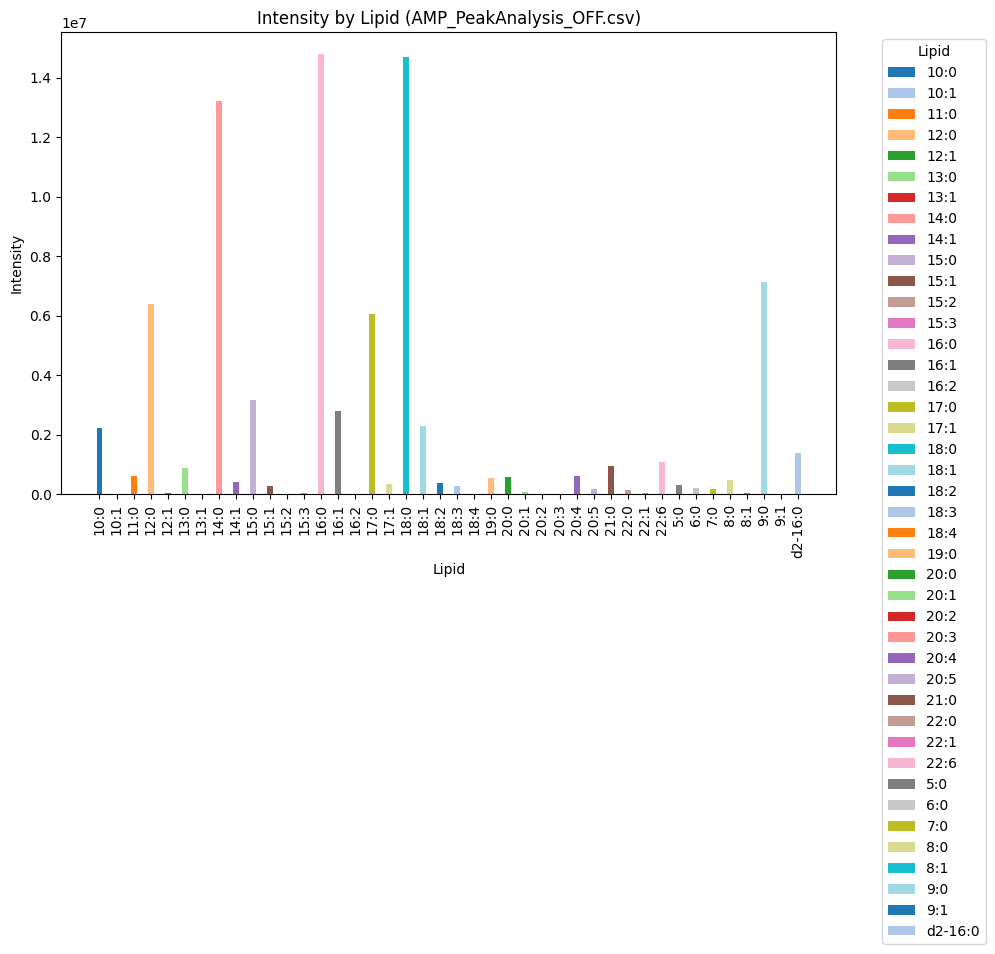

In [22]:


# Initialize the Plot class
plotter = Plot(csv_data_folder, peak_analysis_csv_on, peak_analysis_csv_off, ozone_compare_csv, plots_directory)

# Create a scatter plot with use_ozone_compare argument
plotter.scatter(use_ozone_compare=False, mode=mode)

# Create a bar plot with use_ozone_compare argument
plotter.plot_bar(use_ozone_compare=False, mode=mode)


# # Create bar plots by group sample with use_ozone_compare argument
# plotter.plot_bar_by_group_sample(use_ozone_compare=True, mode='ON', group_type='Match_Group')


Looking for CSV file at: ./Projects/AMP/results/C_test/csv_data/C_test_OFF.csv_OzoneCompared.csv
Loaded DataFrame with 332 rows and 19 columns.
DataFrame columns: Index(['Lipid', 'Retention_Time', 'OzESI_Intensity', 'Match_Group',
       'Group_Sample', 'Sample_ID', 'Parent_Ion', 'Product_Ion', 'FAC',
       'Biology', 'Genotype', 'Cage', 'Mouse', 'Peak_Height', 'FWHM',
       'Peak_Width', 'Peak_Area', 'FAC_OFF', 'Retention_Time_OFF'],
      dtype='object')
Directory already exists at Projects/AMP/results/C_test/plots/off/
Grouped Data:                                                Lipid  OzESI_Intensity
0  10:0 / 18:2 (9Z,12Z)n-6,n-9 / 14:1 (9Z)n-5 / 1...     6.856845e+05
1               11:0 / 15:1 (10Z)n-5 / 17:1 (10Z)n-7     1.023703e+05
2                                               16:1     1.348215e+05
3                                               18:1     4.424109e+05
4                       18:2 / 20:3 (11Z,14Z,17Z)n-3     5.868634e+04
5  20:3 (8Z,11Z,14Z)n-6,n-9,n-12 / 1

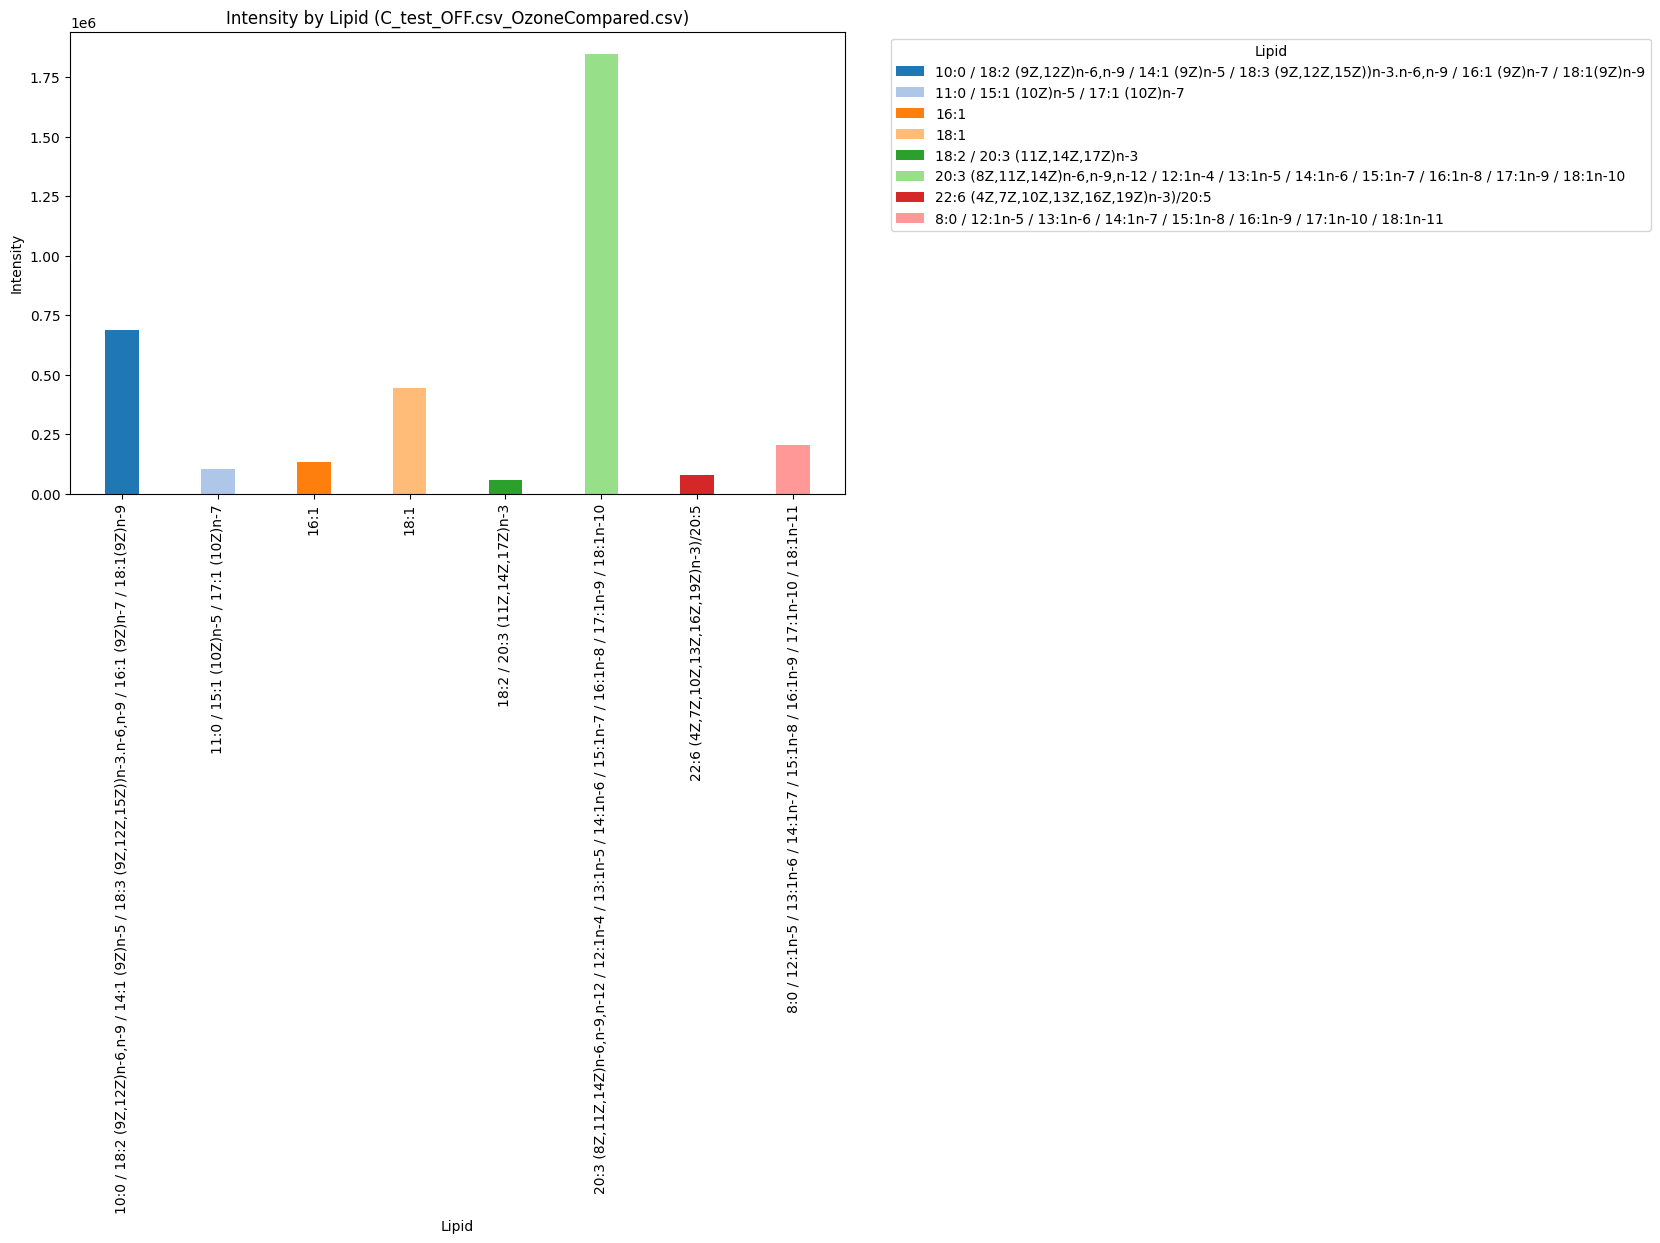

In [18]:
# Create a bar plot with use_ozone_compare argument
plotter.plot_bar(use_ozone_compare=True, mode=mode)

Looking for CSV file at: ./Projects/AMP/results/C_test/csv_data/C_test_PeakAnalysis_OFF.csv
Loaded DataFrame with 390 rows and 17 columns.
DataFrame columns: Index(['Lipid', 'Retention_Time', 'OzESI_Intensity', 'Match_Group',
       'Group_Sample', 'Sample_ID', 'Parent_Ion', 'Product_Ion', 'FAC',
       'Biology', 'Genotype', 'Cage', 'Mouse', 'Peak_Height', 'FWHM',
       'Peak_Width', 'Peak_Area'],
      dtype='object')
Directory already exists at Projects/AMP/results/C_test/plots/off/


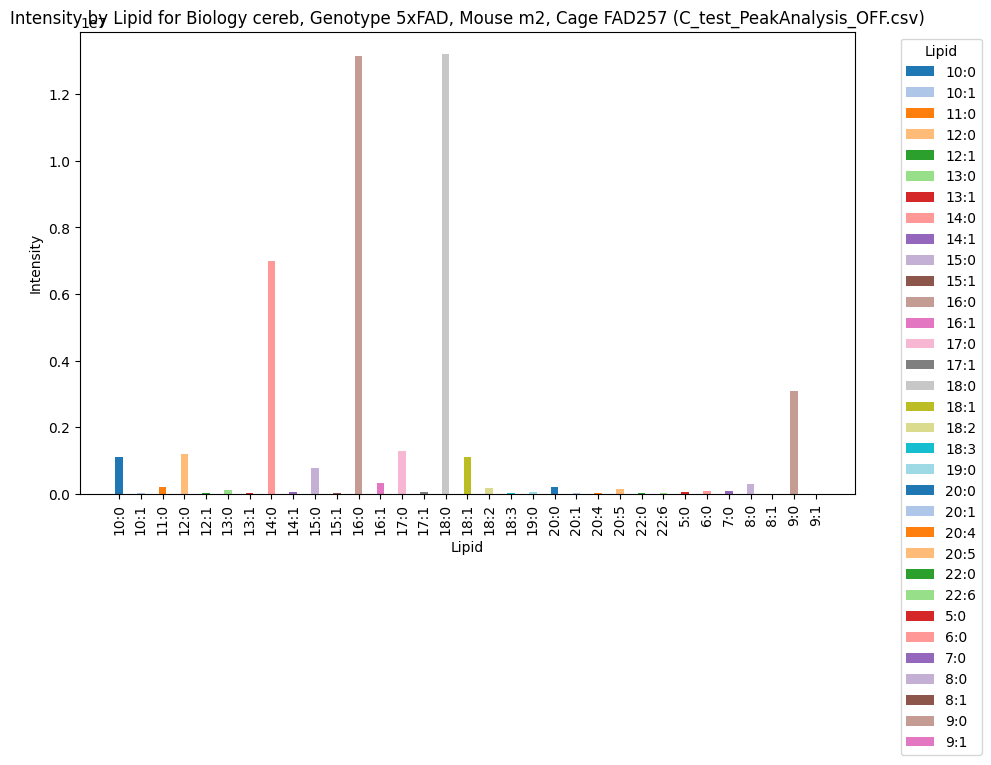

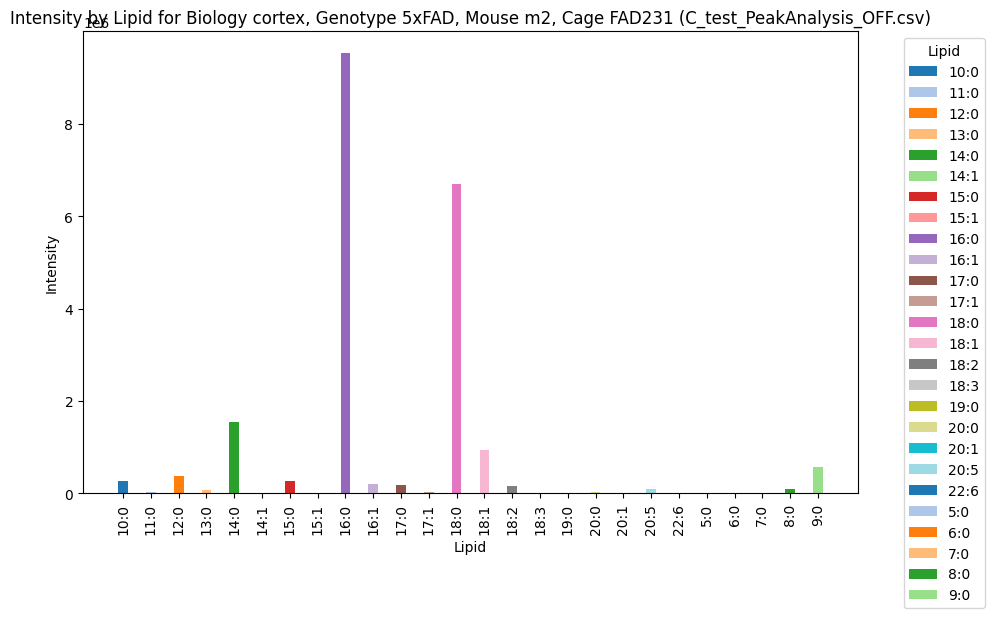

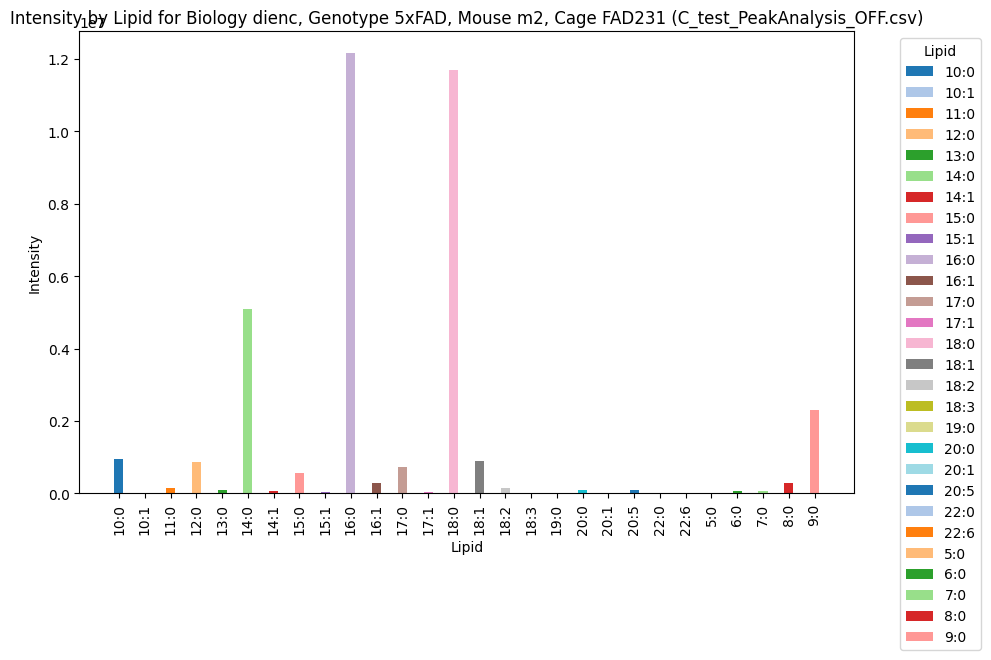

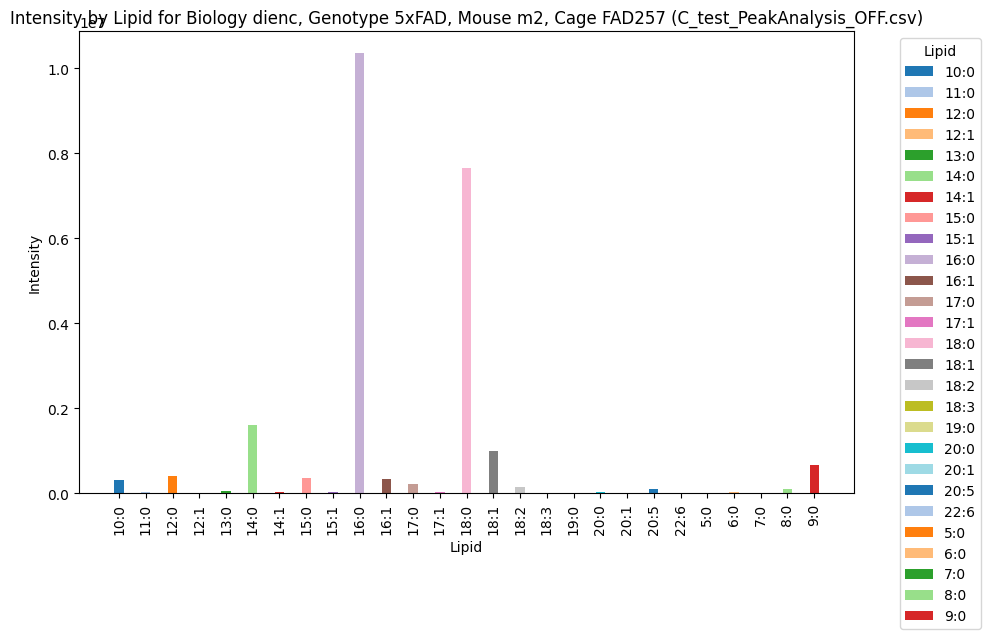

In [19]:
plotter.plot_bar_by_group_sample(use_ozone_compare=False, mode=mode, group_type='Group_Sample')

Looking for CSV file at: ./Projects/AMP/results/C_test/csv_data/C_test_OFF.csv_OzoneCompared.csv
Loaded DataFrame with 332 rows and 19 columns.
DataFrame columns: Index(['Lipid', 'Retention_Time', 'OzESI_Intensity', 'Match_Group',
       'Group_Sample', 'Sample_ID', 'Parent_Ion', 'Product_Ion', 'FAC',
       'Biology', 'Genotype', 'Cage', 'Mouse', 'Peak_Height', 'FWHM',
       'Peak_Width', 'Peak_Area', 'FAC_OFF', 'Retention_Time_OFF'],
      dtype='object')
Directory already exists at Projects/AMP/results/C_test/plots/off/


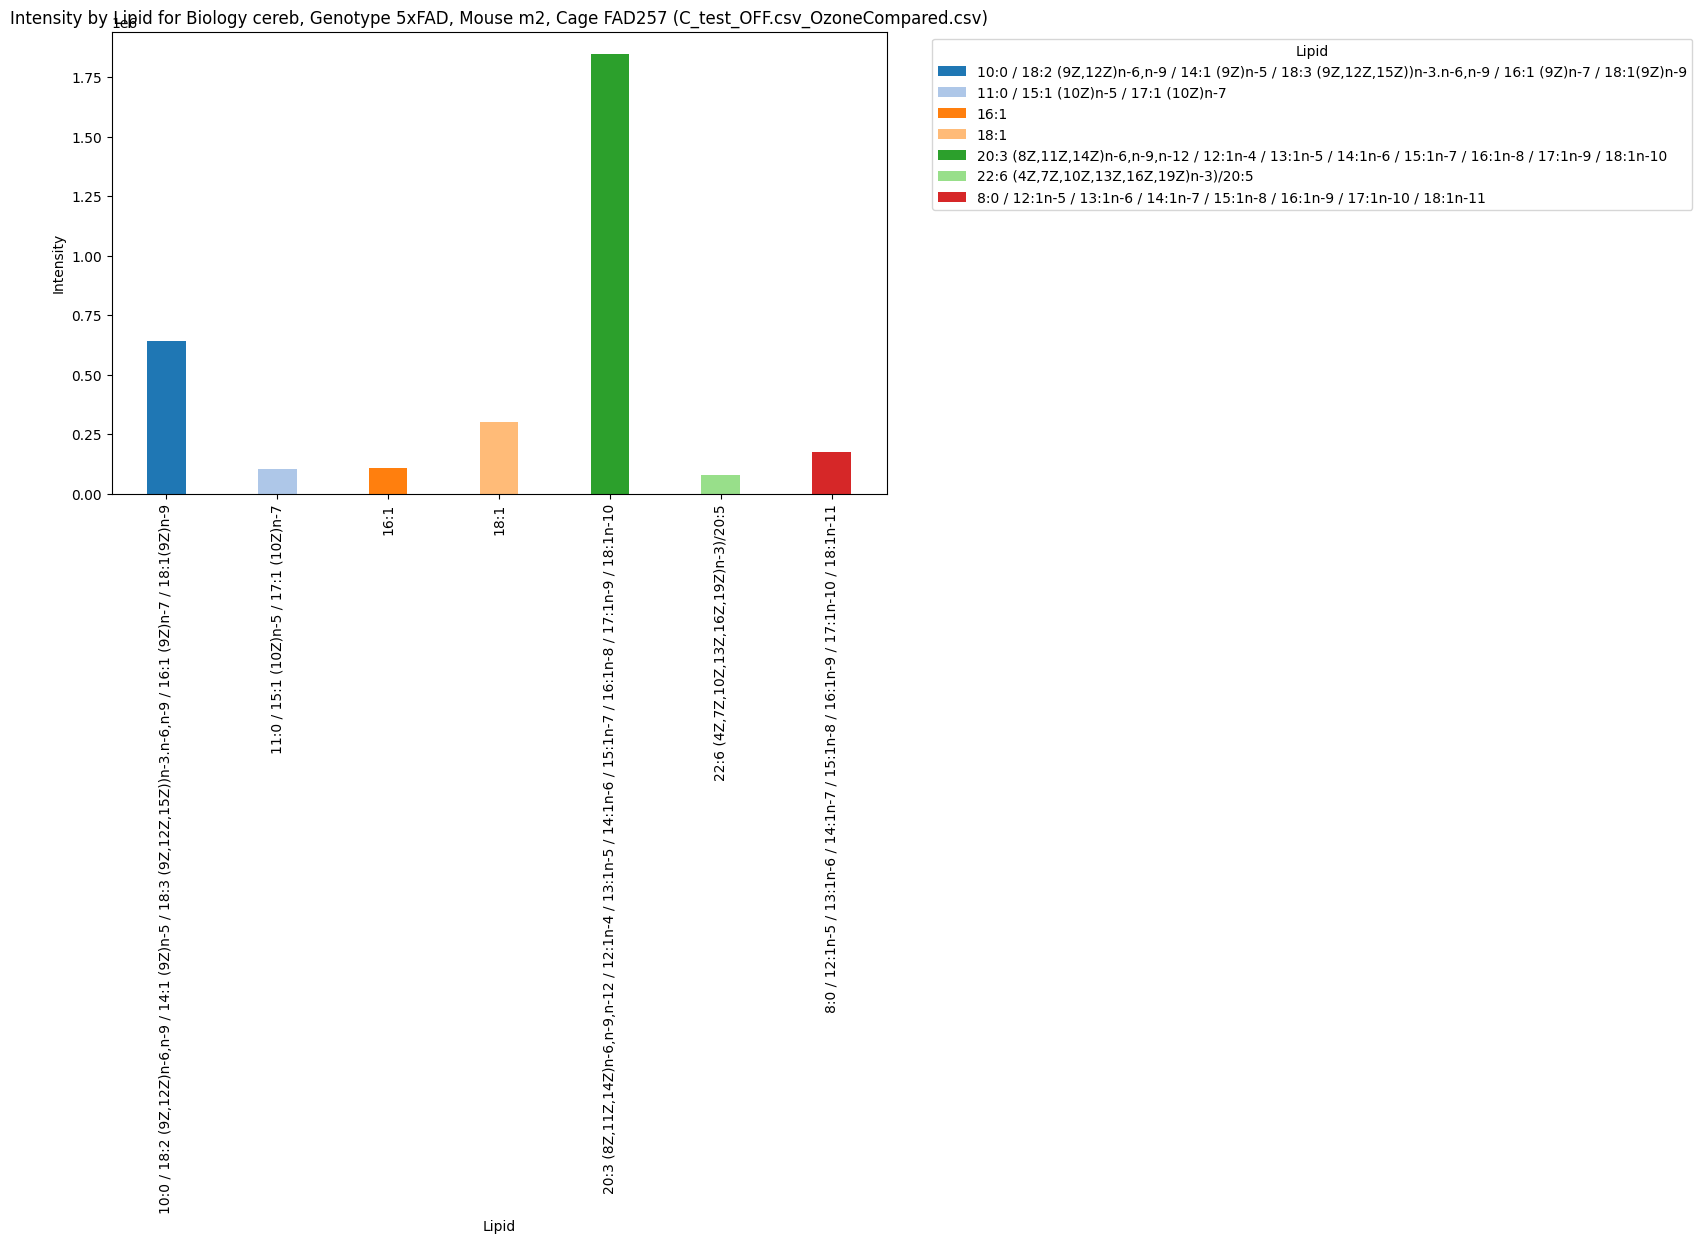

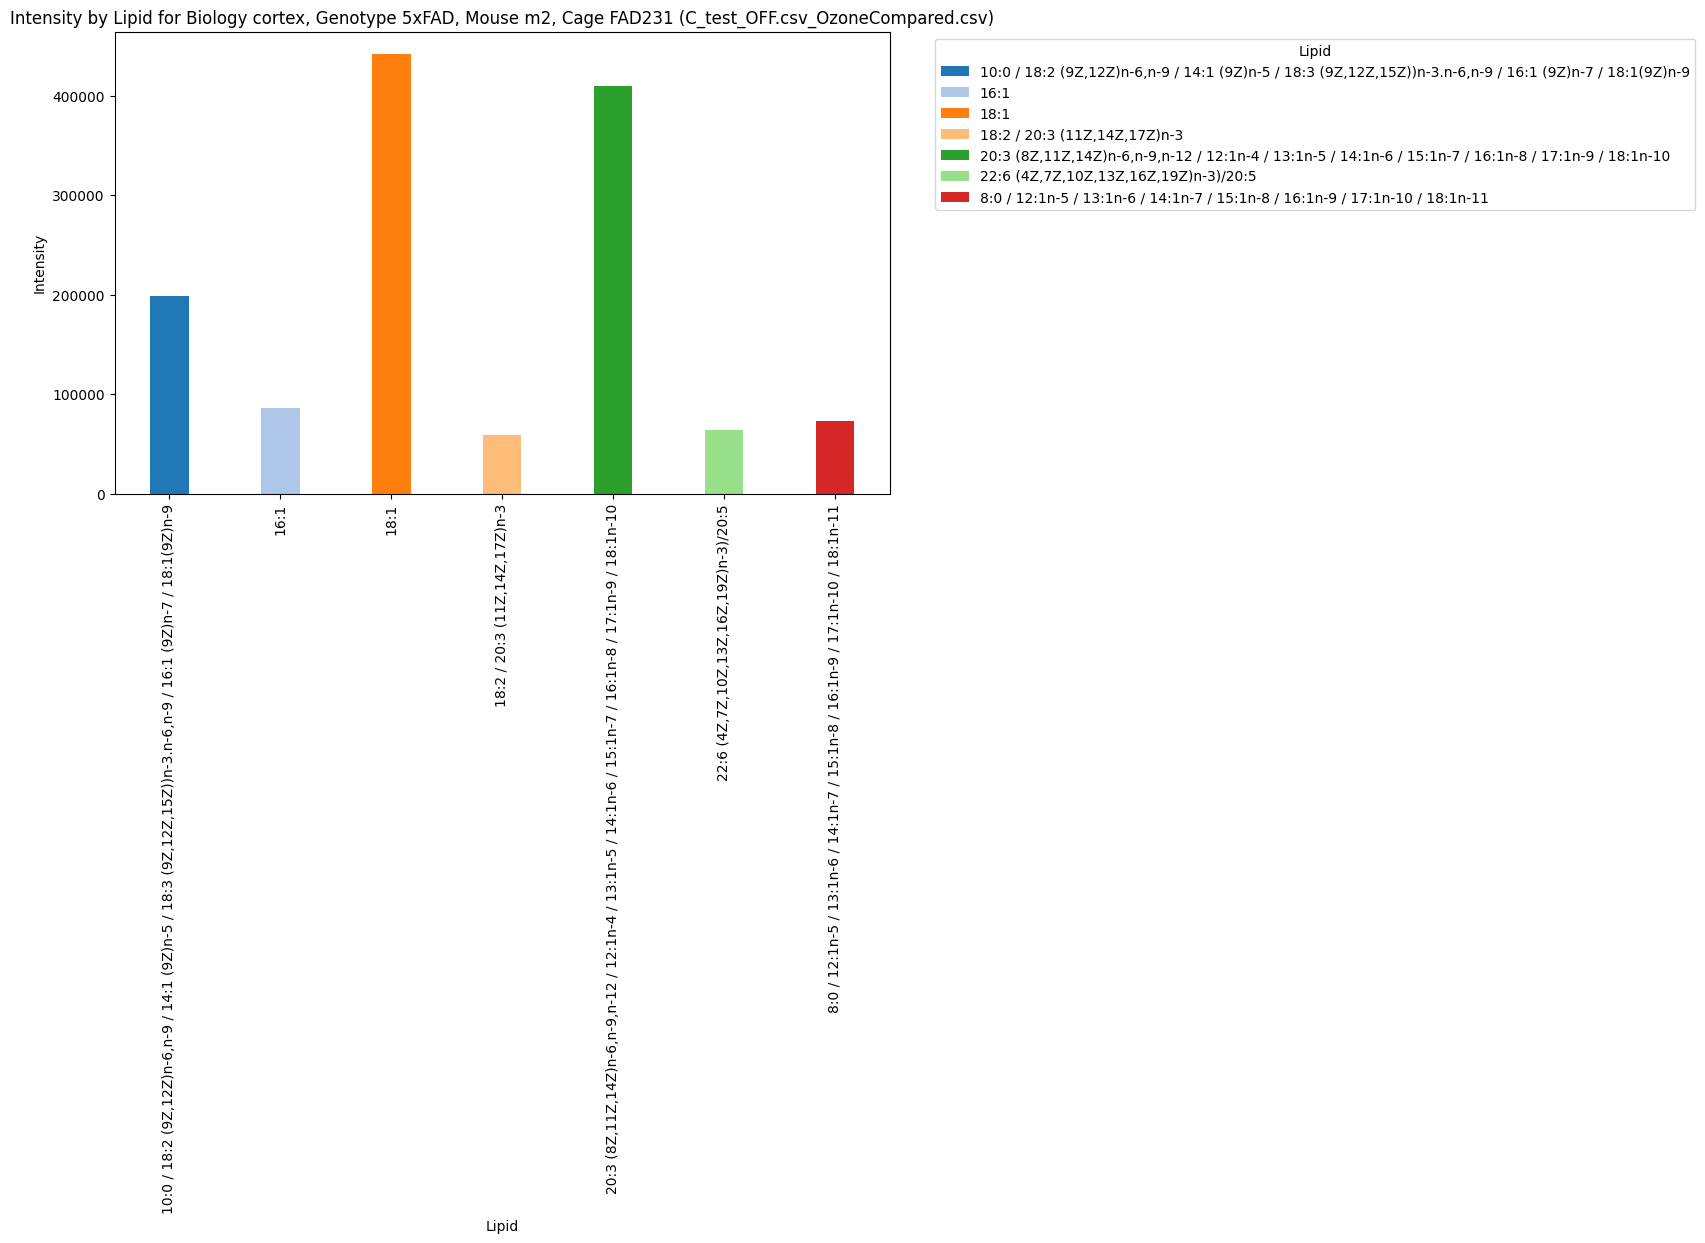

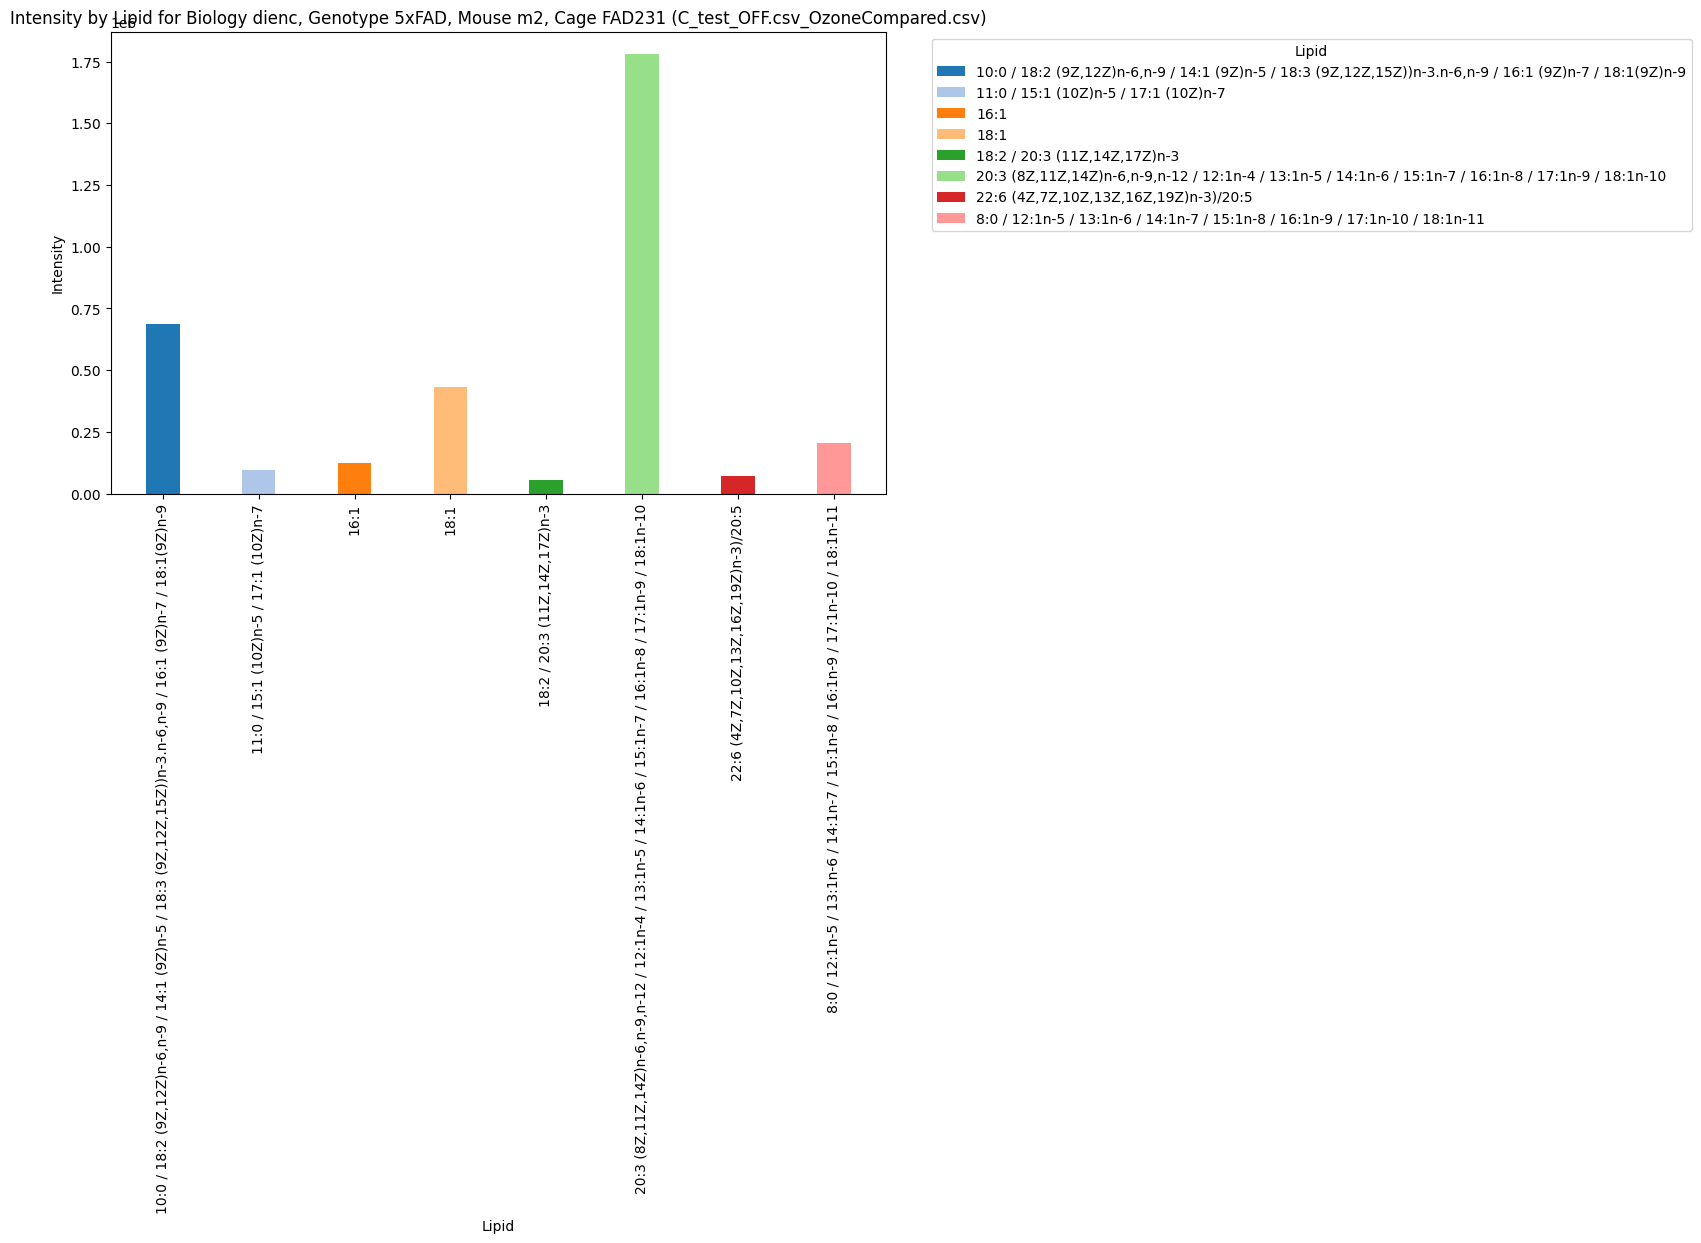

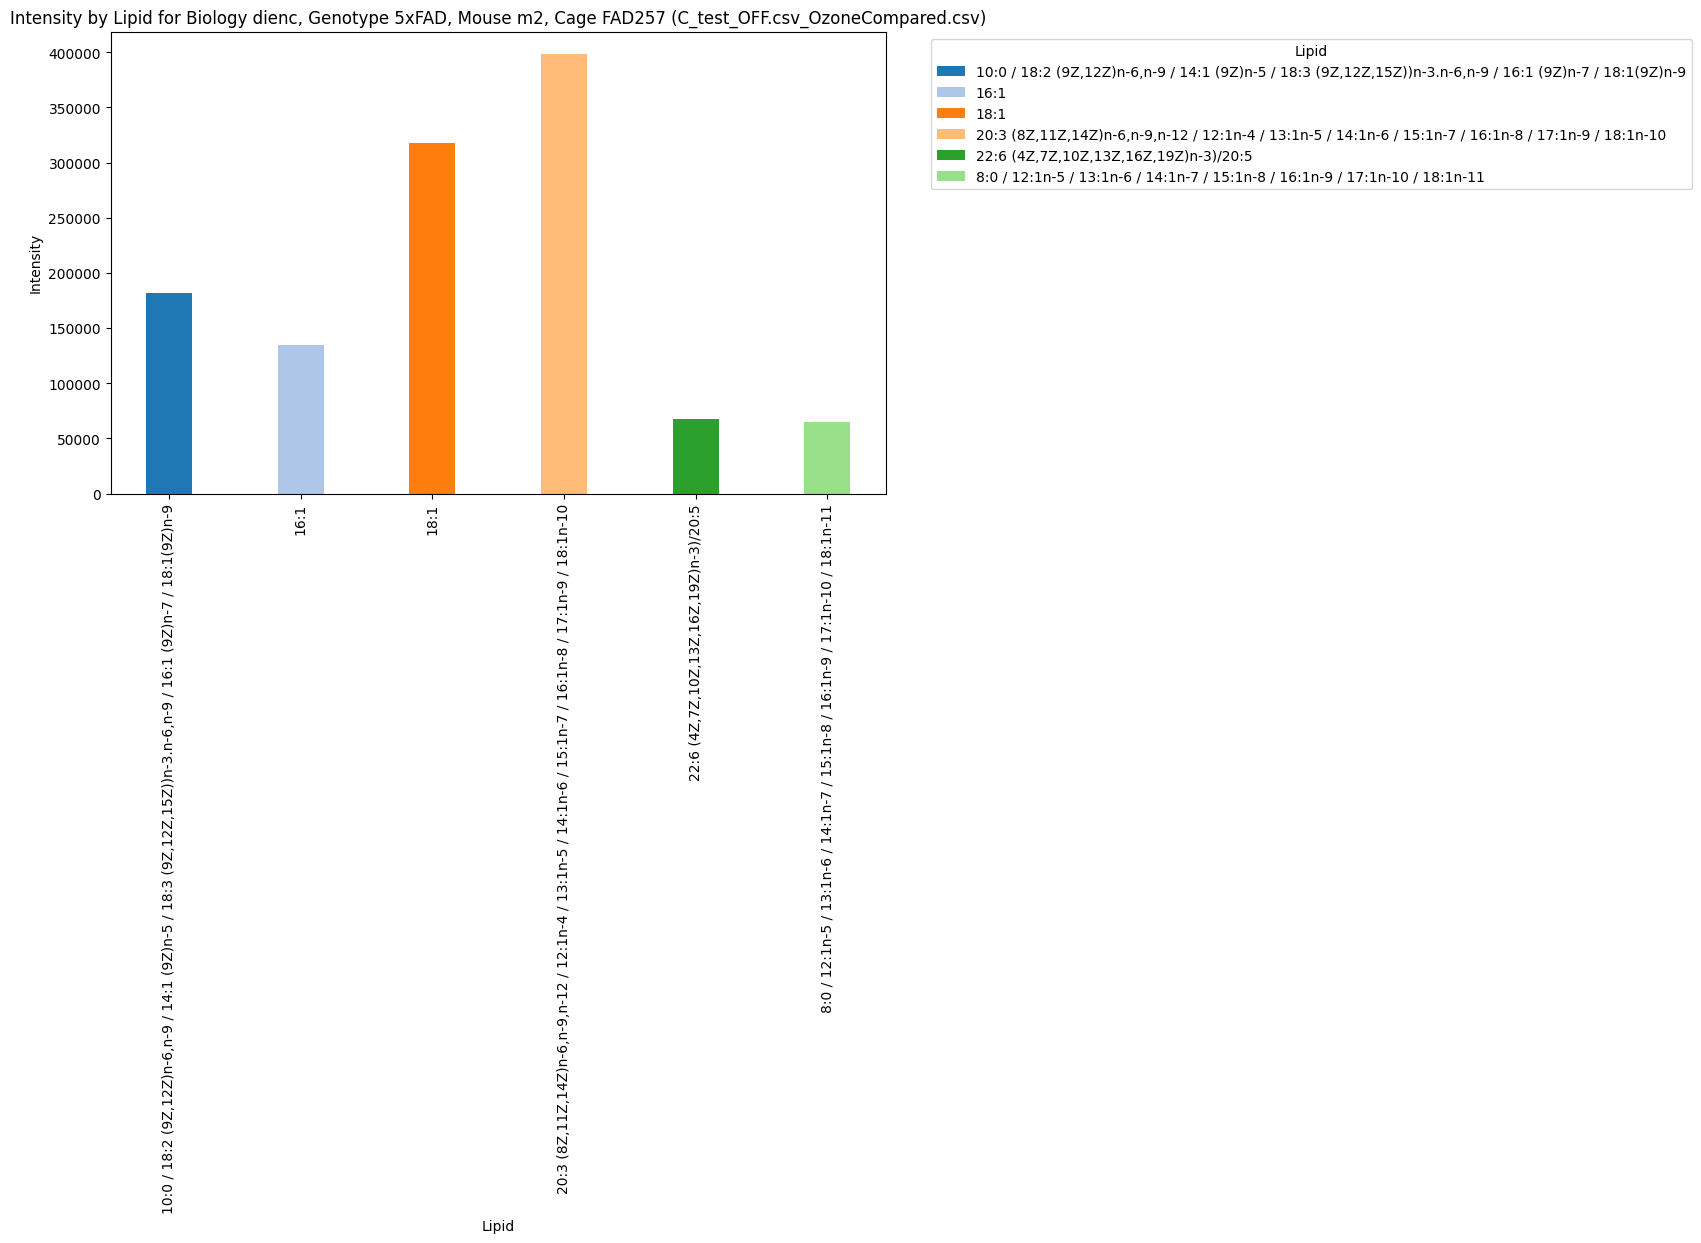

In [20]:
plotter.plot_bar_by_group_sample(use_ozone_compare=True, mode=mode, group_type='Group_Sample')